# Why "Doubly Robust"?

**Chapter 12, Section 2**

This notebook proves why the DR estimator only needs ONE model to be correct.

## Table of Contents
1. [Intuition](#intuition) - Belt and suspenders
2. [Formal Treatment](#formal) - Proofs of double robustness
3. [Numeric Demonstration](#numeric) - Deliberate misspecification
4. [Implementation](#implementation) - Testing robustness
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression, LinearRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The "Belt and Suspenders" Principle

**Single-model risk**:
- If your one model is wrong, your estimate is biased
- You're betting everything on one specification

**Double robustness**:
- Two independent "safety nets"
- If either catches you, you're safe
- Only fail if BOTH models are wrong

### How Does This Work?

| Scenario | Outcome Model | PS Model | DR Estimate |
|----------|---------------|----------|-------------|
| Best case | ✓ Correct | ✓ Correct | Consistent + Efficient |
| Case 2 | ✓ Correct | ✗ Wrong | Consistent |
| Case 3 | ✗ Wrong | ✓ Correct | Consistent |
| Worst case | ✗ Wrong | ✗ Wrong | Potentially biased |

---

In [2]:
# Create a simulated dataset with KNOWN truth
np.random.seed(42)
n = 5000

# Covariates
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# True propensity score model: logistic in X1 + X2
logit_ps = -0.5 + 0.8 * X1 + 0.6 * X2
ps_true = 1 / (1 + np.exp(-logit_ps))
T = np.random.binomial(1, ps_true)

# True outcome model: linear in X1 + X2 + T
TRUE_ATE = 2.0
Y0 = 1 + 1.5 * X1 + 0.8 * X2 + np.random.normal(0, 1, n)
Y1 = Y0 + TRUE_ATE
Y = T * Y1 + (1 - T) * Y0

# Combine into dataframe
sim_data = pd.DataFrame({
    'X1': X1, 'X2': X2, 'T': T, 'Y': Y
})

print(f"Simulated data: n={n}")
print(f"True ATE: {TRUE_ATE}")
print(f"Treatment rate: {T.mean():.1%}")

Simulated data: n=5000
True ATE: 2.0
Treatment rate: 39.8%


---

## Formal Treatment

### Proof: If Outcome Model is Correct

**Setup**: Let $\mu_t(X) = E[Y|T=t, X]$ be the true conditional mean.

**DR estimator**:
$$\hat{\tau}_{DR} = \frac{1}{n}\sum \left[ \mu_1(X) - \mu_0(X) + \frac{T(Y - \mu_1(X))}{\hat{e}(X)} - \frac{(1-T)(Y - \mu_0(X))}{1-\hat{e}(X)} \right]$$

**When $\mu_t$ is correct**:
- $E[Y - \mu_1(X) | T=1, X] = 0$ (residuals have zero mean)
- $E[Y - \mu_0(X) | T=0, X] = 0$

**Therefore**:
$$E\left[\frac{T(Y - \mu_1(X))}{\hat{e}(X)}\right] = E\left[E\left[\frac{T(Y - \mu_1(X))}{\hat{e}(X)} \Big| X\right]\right] = 0$$

The IPTW correction terms vanish, leaving just the outcome model.

---

### Proof: If PS Model is Correct

**Setup**: Let $e(X) = P(T=1|X)$ be the true propensity score.

**The IPTW part provides**:
$$E\left[\frac{TY}{e(X)}\right] = E\left[E\left[\frac{TY}{e(X)} \Big| X\right]\right] = E\left[\frac{e(X) \cdot E[Y|T=1, X]}{e(X)}\right] = E[Y(1)]$$

**Key insight**: Even if $\hat{\mu}_t$ is wrong, the IPTW correction "fixes" the bias because:

$$E\left[\mu_1(X) + \frac{T(Y - \mu_1(X))}{e(X)}\right] = E[\mu_1(X)] + E[Y(1)] - E[\mu_1(X)] = E[Y(1)]$$

The errors in $\mu_1$ cancel out!

---

In [3]:
def dr_estimator(Y, T, X, ps, mu1, mu0):
    """DR estimator given PS and outcome predictions."""
    dr_i = (mu1 - mu0 + 
            T * (Y - mu1) / ps - 
            (1 - T) * (Y - mu0) / (1 - ps))
    return dr_i.mean()

def iptw_estimator(Y, T, ps):
    """Hajek IPTW estimator."""
    mu1 = np.sum(T * Y / ps) / np.sum(T / ps)
    mu0 = np.sum((1 - T) * Y / (1 - ps)) / np.sum((1 - T) / (1 - ps))
    return mu1 - mu0

def outcome_regression(Y, T, mu1, mu0):
    """Pure outcome regression estimator."""
    return (mu1 - mu0).mean()

---

## Numeric Demonstration

### Scenario 1: Both Models Correct

In [4]:
# Correct PS model
X_full = sim_data[['X1', 'X2']].values
ps_correct = LogisticRegression(C=1e6).fit(X_full, T).predict_proba(X_full)[:, 1]

# Correct outcome models
mu1_correct = LinearRegression().fit(X_full[T==1], Y[T==1]).predict(X_full)
mu0_correct = LinearRegression().fit(X_full[T==0], Y[T==0]).predict(X_full)

# Estimates
dr_both = dr_estimator(Y, T, X_full, ps_correct, mu1_correct, mu0_correct)
iptw_both = iptw_estimator(Y, T, ps_correct)
or_both = outcome_regression(Y, T, mu1_correct, mu0_correct)

print("SCENARIO 1: Both Models Correct")
print("=" * 50)
print(f"True ATE:          {TRUE_ATE:.4f}")
print(f"DR:                {dr_both:.4f} (bias: {dr_both - TRUE_ATE:.4f})")
print(f"IPTW:              {iptw_both:.4f} (bias: {iptw_both - TRUE_ATE:.4f})")
print(f"Outcome Reg:       {or_both:.4f} (bias: {or_both - TRUE_ATE:.4f})")

SCENARIO 1: Both Models Correct
True ATE:          2.0000
DR:                1.9534 (bias: -0.0466)
IPTW:              1.9915 (bias: -0.0085)
Outcome Reg:       1.9501 (bias: -0.0499)


### Scenario 2: Correct Outcome Model, Wrong PS Model

In [5]:
# WRONG PS model: omit X2
ps_wrong = LogisticRegression(C=1e6).fit(X_full[:, 0:1], T).predict_proba(X_full[:, 0:1])[:, 1]

# Correct outcome models (as before)
# mu1_correct, mu0_correct already computed

# Estimates
dr_wrong_ps = dr_estimator(Y, T, X_full, ps_wrong, mu1_correct, mu0_correct)
iptw_wrong_ps = iptw_estimator(Y, T, ps_wrong)

print("SCENARIO 2: Correct Outcome, Wrong PS")
print("=" * 50)
print(f"True ATE:          {TRUE_ATE:.4f}")
print(f"DR:                {dr_wrong_ps:.4f} (bias: {dr_wrong_ps - TRUE_ATE:.4f})")
print(f"IPTW (wrong PS):   {iptw_wrong_ps:.4f} (bias: {iptw_wrong_ps - TRUE_ATE:.4f})")
print(f"Outcome Reg:       {or_both:.4f} (bias: {or_both - TRUE_ATE:.4f})")
print("\n=> DR remains accurate despite wrong PS!")

SCENARIO 2: Correct Outcome, Wrong PS
True ATE:          2.0000
DR:                1.9557 (bias: -0.0443)
IPTW (wrong PS):   2.4306 (bias: 0.4306)
Outcome Reg:       1.9501 (bias: -0.0499)

=> DR remains accurate despite wrong PS!


### Scenario 3: Wrong Outcome Model, Correct PS Model

In [6]:
# Correct PS model
# ps_correct already computed

# WRONG outcome models: omit X2
mu1_wrong = LinearRegression().fit(X_full[T==1, 0:1], Y[T==1]).predict(X_full[:, 0:1])
mu0_wrong = LinearRegression().fit(X_full[T==0, 0:1], Y[T==0]).predict(X_full[:, 0:1])

# Estimates
dr_wrong_out = dr_estimator(Y, T, X_full, ps_correct, mu1_wrong, mu0_wrong)
or_wrong_out = outcome_regression(Y, T, mu1_wrong, mu0_wrong)

print("SCENARIO 3: Wrong Outcome, Correct PS")
print("=" * 50)
print(f"True ATE:          {TRUE_ATE:.4f}")
print(f"DR:                {dr_wrong_out:.4f} (bias: {dr_wrong_out - TRUE_ATE:.4f})")
print(f"IPTW:              {iptw_both:.4f} (bias: {iptw_both - TRUE_ATE:.4f})")
print(f"Outcome (wrong):   {or_wrong_out:.4f} (bias: {or_wrong_out - TRUE_ATE:.4f})")
print("\n=> DR remains accurate despite wrong outcome model!")

SCENARIO 3: Wrong Outcome, Correct PS
True ATE:          2.0000
DR:                1.9686 (bias: -0.0314)
IPTW:              1.9915 (bias: -0.0085)
Outcome (wrong):   2.4106 (bias: 0.4106)

=> DR remains accurate despite wrong outcome model!


### Scenario 4: Both Models Wrong

In [7]:
# Both wrong (omit X2 from both)
dr_both_wrong = dr_estimator(Y, T, X_full, ps_wrong, mu1_wrong, mu0_wrong)

print("SCENARIO 4: Both Models Wrong")
print("=" * 50)
print(f"True ATE:          {TRUE_ATE:.4f}")
print(f"DR:                {dr_both_wrong:.4f} (bias: {dr_both_wrong - TRUE_ATE:.4f})")
print(f"IPTW (wrong):      {iptw_wrong_ps:.4f} (bias: {iptw_wrong_ps - TRUE_ATE:.4f})")
print(f"Outcome (wrong):   {or_wrong_out:.4f} (bias: {or_wrong_out - TRUE_ATE:.4f})")
print("\n=> DR is biased when BOTH models are wrong")

SCENARIO 4: Both Models Wrong
True ATE:          2.0000
DR:                2.4219 (bias: 0.4219)
IPTW (wrong):      2.4306 (bias: 0.4306)
Outcome (wrong):   2.4106 (bias: 0.4106)

=> DR is biased when BOTH models are wrong


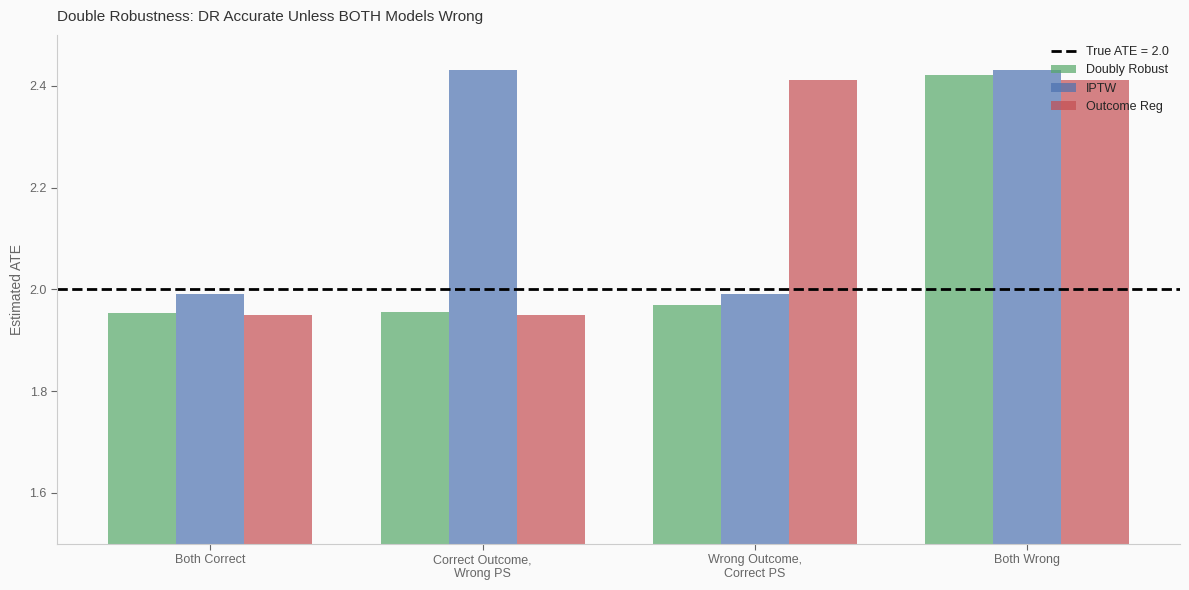

In [8]:
# Summary visualization
fig, ax = create_tufte_figure(figsize=(12, 6))

scenarios = ['Both Correct', 'Correct Outcome,\nWrong PS', 'Wrong Outcome,\nCorrect PS', 'Both Wrong']
dr_estimates = [dr_both, dr_wrong_ps, dr_wrong_out, dr_both_wrong]
iptw_estimates = [iptw_both, iptw_wrong_ps, iptw_both, iptw_wrong_ps]
or_estimates = [or_both, or_both, or_wrong_out, or_wrong_out]

x = np.arange(len(scenarios))
width = 0.25

ax.bar(x - width, dr_estimates, width, label='Doubly Robust', color=COLORS['green'], alpha=0.7)
ax.bar(x, iptw_estimates, width, label='IPTW', color=COLORS['blue'], alpha=0.7)
ax.bar(x + width, or_estimates, width, label='Outcome Reg', color=COLORS['red'], alpha=0.7)
ax.axhline(TRUE_ATE, color='black', linestyle='--', linewidth=2, label=f'True ATE = {TRUE_ATE}')

ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_ylim(1.5, 2.5)
ax.legend(frameon=False, loc='upper right')

set_tufte_title(ax, "Double Robustness: DR Accurate Unless BOTH Models Wrong")
set_tufte_labels(ax, "", "Estimated ATE")

plt.tight_layout()
plt.show()

---

## Implementation

### Summary Table

In [9]:
# Create summary table
print("DOUBLE ROBUSTNESS SUMMARY:")
print("=" * 70)
print(f"{'Scenario':<30} {'DR':>10} {'IPTW':>10} {'Outcome':>10} {'Best':>8}")
print("-" * 70)

results = [
    ('Both Correct', dr_both, iptw_both, or_both),
    ('Correct Outcome, Wrong PS', dr_wrong_ps, iptw_wrong_ps, or_both),
    ('Wrong Outcome, Correct PS', dr_wrong_out, iptw_both, or_wrong_out),
    ('Both Wrong', dr_both_wrong, iptw_wrong_ps, or_wrong_out),
]

for scenario, dr, iptw, out_reg in results:
    biases = [abs(dr - TRUE_ATE), abs(iptw - TRUE_ATE), abs(out_reg - TRUE_ATE)]
    best = ['DR', 'IPTW', 'Outcome'][np.argmin(biases)]
    print(f"{scenario:<30} {dr:>10.4f} {iptw:>10.4f} {out_reg:>10.4f} {best:>8}")

print("-" * 70)
print(f"{'True ATE':<30} {TRUE_ATE:>10.4f}")
print("\n=> DR is best or tied in 3/4 scenarios!")

DOUBLE ROBUSTNESS SUMMARY:
Scenario                               DR       IPTW    Outcome     Best
----------------------------------------------------------------------
Both Correct                       1.9534     1.9915     1.9501     IPTW
Correct Outcome, Wrong PS          1.9557     2.4306     1.9501       DR
Wrong Outcome, Correct PS          1.9686     1.9915     2.4106     IPTW
Both Wrong                         2.4219     2.4306     2.4106  Outcome
----------------------------------------------------------------------
True ATE                           2.0000

=> DR is best or tied in 3/4 scenarios!


---

## Interview Appendix

### Practice Questions

**Q1: Why is the DR estimator called "doubly robust"?**

<details>
<summary>Solution</summary>

**Definition**: DR is consistent if EITHER the propensity score model OR the outcome model is correctly specified.

**Mechanism**:
1. If outcome model is correct:
   - IPTW correction terms have expectation zero
   - $E[Y - \mu_t(X)|T=t, X] = 0$ by definition
   - Estimate equals outcome model estimate

2. If PS model is correct:
   - IPTW provides consistent correction
   - Outcome model errors "cancel out"
   - $E[\mu_t(X) + \text{correction}] = E[Y(t)]$

**Key insight**: Two independent "safety nets" - only fail if both are wrong.

</details>

**Q2: Can you prove that DR is consistent when only the outcome model is correct?**

<details>
<summary>Solution</summary>

**Proof sketch**:

When $\mu_t(X) = E[Y|T=t, X]$ (correct outcome model):

$$E\left[\frac{T(Y - \mu_1(X))}{\hat{e}(X)} \Big| X\right] = \frac{P(T=1|X)}{\hat{e}(X)} \cdot E[Y - \mu_1(X)|T=1, X]$$

Since $E[Y|T=1, X] = \mu_1(X)$ by assumption:
$$E[Y - \mu_1(X)|T=1, X] = 0$$

Therefore the IPTW correction term vanishes:
$$E\left[\frac{T(Y - \mu_1(X))}{\hat{e}(X)}\right] = 0$$

And DR reduces to:
$$E[\hat{\tau}_{DR}] = E[\mu_1(X) - \mu_0(X)] = \tau$$

</details>

**Q3: What happens to the DR estimator when both models are wrong?**

<details>
<summary>Solution</summary>

**Short answer**: DR can be biased, but often less biased than single-model approaches.

**Details**:
- The bias depends on the "cross-product" of the two model errors
- If errors are small or uncorrelated, bias is small
- If errors are large and correlated, bias can be substantial

**Bias formula** (informal):
$$\text{Bias}_{DR} \approx O(\text{PS error} \times \text{Outcome error})$$

Compare to single-model approaches:
$$\text{Bias}_{IPTW} \approx O(\text{PS error})$$
$$\text{Bias}_{OR} \approx O(\text{Outcome error})$$

**Practical implication**: Use flexible models (RF, boosting) to minimize both errors.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 12.

[^2]: Robins, J. M., Rotnitzky, A., & Zhao, L. P. (1994). Estimation of regression coefficients when some regressors are not always observed. *JASA*, 89(427), 846-866.

[^3]: Kang, J. D., & Schafer, J. L. (2007). Demystifying double robustness. *Statistical Science*, 22(4), 523-539.

[^4]: Cross-reference: Double ML in `22_debiased_ml/` uses orthogonality for similar robustness.